## Compute corrected sea surface heights & anomalies from Jason-3 ##

** Import libraries **

In [1]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
%matplotlib inline
from mpl_toolkits.basemap import Basemap

plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()

input_root = '../data/'
input_path = ''
input_file = 'JA3_GPN_2PdP050_126_20170622_042327_20170622_051940.nc'
my_file    = os.path.join(input_root,input_path,input_file)
nc = Dataset(my_file, 'r')

** define the variables to use **<br>
We have to define the variables available within the file that we wish to use - here to compute corrected SSH and SLA<br>
Corrected sea surface height =
Altitude - range    - atmosphere propagation corrections (dry & wet troposphere, electrons in the ionosphere: delays in the radar wave propagation) - tides (ocean, solid earth and pole) - atmospheric loading (pressure & hf winds) - sea state bias (NB. note that ALL corrections are removed from the raw SSH)<br>
then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (SLAs) or geoid (ADT), or nothing (SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

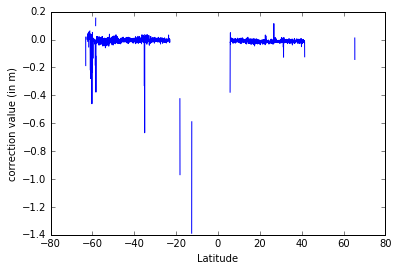

In [2]:
#below we define the parameters we will need to compute a sea level anomaly, edit it from erroneous data

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]

range_ku = nc.variables['range_ku'][:]
alt = nc.variables['alt'][:]

iono_corr_alt_ku = nc.variables['iono_corr_alt_ku'][:]
model_dry_tropo_corr = nc.variables['model_dry_tropo_corr'][:]
rad_wet_tropo_corr = nc.variables['rad_wet_tropo_corr'][:]

ocean_tide_sol1 = nc.variables['ocean_tide_sol1'][:]
solid_earth_tide = nc.variables['solid_earth_tide'][:]
pole_tide = nc.variables['pole_tide'][:]

hf_fluctuations_corr = nc.variables['hf_fluctuations_corr'][:]
inv_bar_corr = nc.variables['inv_bar_corr'][:]

sea_state_bias_ku = nc.variables['sea_state_bias_ku'][:]

geoid = nc.variables['geoid'][:]
mean_sea_surface = nc.variables['mean_sea_surface'][:]
mean_topography = nc.variables['mean_topography'] [:]

#visualize the variables above
fig = plt.figure()
plt.ylabel('correction value (in m)')
plt.xlabel('Latitude')
plt.plot(lat, iono_corr_alt_ku)
#plt.plot(lat, model_dry_tropo_corr)
#plt.plot(lat, rad_wet_tropo_corr)
#plt.plot(lat, ocean_tide_sol1)
#plt.plot(lat, solid_earth_tide)
#plt.plot(lat, pole_tide)
#plt.plot(lat, hf_fluctuations_corr)
#plt.plot(lat, inv_bar_corr)
#plt.plot(lat, sea_state_bias_ku)
plt.show()

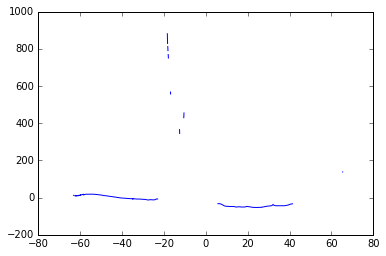

In [3]:
# here are intermediate computations of ssh and sla
# usually, only the full corrected ones are used
raw_ssh = alt - range_ku
raw_sla = (alt - range_ku) - mean_sea_surface
sla_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
sla_iono_drytropocorr = sla_ionocorr - model_dry_tropo_corr
sla_iono_radtropocorr = sla_iono_drytropocorr - rad_wet_tropo_corr
sla_iono_tropo_tides_corr = sla_iono_radtropocorr - ocean_tide_sol1 - solid_earth_tide - pole_tide
tides = (ocean_tide_sol1 - solid_earth_tide) - pole_tide
sla_iono_tropo_tides_ssb_corr = sla_iono_tropo_tides_corr - sea_state_bias_ku
sla_fullcorr = sla_iono_tropo_tides_ssb_corr - (hf_fluctuations_corr + inv_bar_corr)
dynatmcorr = hf_fluctuations_corr + inv_bar_corr
adt = sla_fullcorr + mean_topography

#plot e.g. a "raw" version of SSH (un-corrected)
lat = nc.variables['lat'][:]
fig = plt.figure()
plt.plot(lat, raw_ssh)
plt.show()

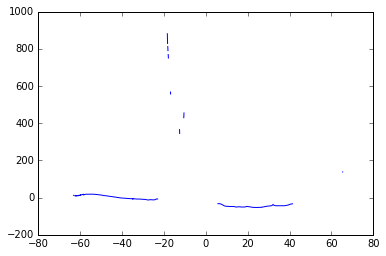

In [4]:
#plot of a "raw" version of SSH (un-corrected)
lat = nc.variables['lat'][:]
fig = plt.figure()
plt.plot(lat, raw_ssh)
plt.show()

Note the amplitude, and note also the very extreme data.
** have a look at the SLA **
note the same - amplitude, and the extreme data

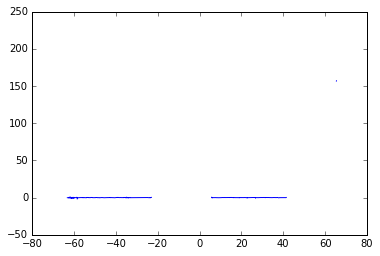

In [5]:
#or corrected sla
lat = nc.variables['lat'][:]
fig = plt.figure()
plt.plot(lat, sla_fullcorr)
plt.show()

** looking at a major current **
the graph above shows a whole track (half orbit); a smaller area can be easier to interpret. We will focus on the North Atlantic (Gulf Stream), i.e. restrict the graph to a latitude between 0 and 45°N. 
You may need to adapt the axis to the area/date you are looking at. Zoom over another region and look at the extrema values

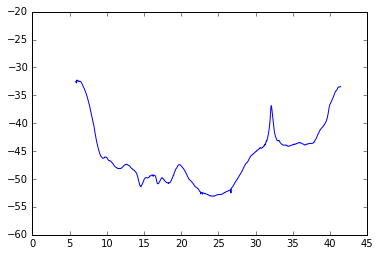

In [6]:
# zoom on an area and adapt the scale
lat = nc.variables['lat'][:]
fig = plt.figure()
plt.plot(lat, raw_ssh)
# we will focus on the North Atlantic (Gulf Stream), lat between 0 and 45
# Activity
# modify the third and fourth values below to adapt the y scale (NB. we are working in meters)
plt.axis([0, 45, -60, -20])
plt.show()

** tests on the variables over the Gulf Stream area **
Try and test different variables as defined above - corrections and intermediate ssh values
modify the min/max in y to better see the amplitude of the curves
ends up with sla_fullcorr

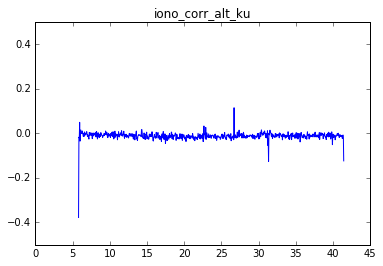

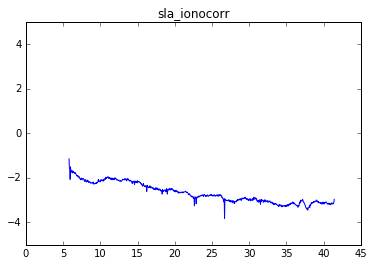

In [7]:
lat = nc.variables['lat'][:]
fig1 = plt.figure()
plt.plot(lat, iono_corr_alt_ku)
plt.title('iono_corr_alt_ku')
plt.axis([0, 45, -0.5, 0.5])

fig2 = plt.figure()
plt.plot(lat, sla_ionocorr)
plt.title('sla_ionocorr')
plt.axis([0, 45, -5, 5])
plt.show()

** Editing **

The data with extreme values do not seem relevant - sea level anomalies of more than 100 meters are not possible. Thus, to use the data, you need to remove the spurious ones. two processes can be used : using the provided flags, or using physical thresholds (using the limitation of the physics or of the algorithms).

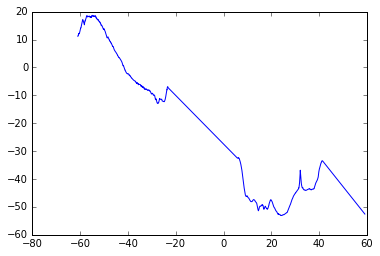

In [8]:
#remove spurious data by "editing"
surface_type = nc.variables['surface_type'][:]
range_numval_ku = nc.variables['range_numval_ku'][:]
range_rms_ku = nc.variables['range_rms_ku'][:]
swh_ku = nc.variables['swh_ku'][:]
sig0_ku = nc.variables['sig0_ku'][:]
wind_speed_alt = nc.variables['wind_speed_alt'][:]
off_nadir_angle_wf_ku = nc.variables['off_nadir_angle_wf_ku'][:]
sig0_numval_ku = nc.variables['sig0_numval_ku'][:]
sig0_rms_ku = nc.variables['sig0_rms_ku'][:]

mask = (surface_type == 0) & (range_numval_ku >= 10) & (range_rms_ku > 0) & (range_rms_ku < 0.2) & (model_dry_tropo_corr > -2.5) & (model_dry_tropo_corr < -1.9) & (rad_wet_tropo_corr > -0.500) & (rad_wet_tropo_corr < -0.001) & (iono_corr_alt_ku > -0.400) & (iono_corr_alt_ku < 0.040) & (sea_state_bias_ku > -0.500) & (sea_state_bias_ku < 0) & (ocean_tide_sol1 > -5) & (ocean_tide_sol1 < 5) & (solid_earth_tide > -1) & (solid_earth_tide < 1) & (pole_tide > -0.150) & (pole_tide < 0.150) & (swh_ku > 0) & (swh_ku < 11) & (sig0_ku > 7) & (sig0_ku < 30) & (wind_speed_alt > 0) & (wind_speed_alt < 30) & ((alt-range_ku) > -130) & ((alt-range_ku) < 100) & (off_nadir_angle_wf_ku > -0.2) & (off_nadir_angle_wf_ku < 0.16) & (( hf_fluctuations_corr + inv_bar_corr) > -2) & (( hf_fluctuations_corr + inv_bar_corr) < 2) & (sig0_numval_ku >= 10) & (sig0_rms_ku > 0) & (sig0_rms_ku < 1) & (sla_fullcorr > -2) & (sla_fullcorr < 2)
sshedited = raw_ssh[mask]
fig = plt.figure()
plt.plot(lat[mask], raw_ssh[mask])
plt.show()

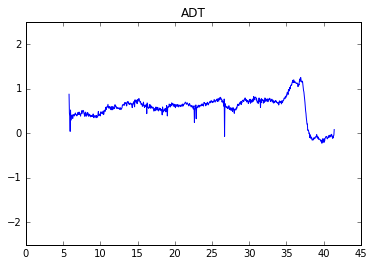

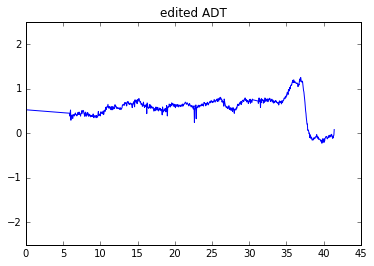

In [9]:
#now, test the "adt" (ssh with respect to the geoid)
lat = nc.variables['lat'][:]
fig1 = plt.figure()
plt.plot(lat, adt)
plt.title('ADT')
plt.axis([0, 45, -2.5, 2.5])

mask = (surface_type == 0) & (model_dry_tropo_corr > -2.5) & (model_dry_tropo_corr < -1.9) & (rad_wet_tropo_corr > -0.500) & (rad_wet_tropo_corr < -0.001) & (iono_corr_alt_ku > -0.400) & (iono_corr_alt_ku < 0.040) & (sea_state_bias_ku > -0.500) & (sea_state_bias_ku < 0) & (ocean_tide_sol1 > -5) & (ocean_tide_sol1 < 5) & (solid_earth_tide > -1) & (solid_earth_tide < 1) & (pole_tide > -0.150) & (pole_tide < 0.150) & (swh_ku > 0) & (swh_ku < 11) & (sig0_ku > 7) & (sig0_ku < 30) & (wind_speed_alt > 0) & (wind_speed_alt < 30) & ((alt-range_ku) > -130) & ((alt-range_ku) < 100) & (( hf_fluctuations_corr + inv_bar_corr) > -2) & (( hf_fluctuations_corr + inv_bar_corr) < 2) &  (sla_fullcorr > -2) & (sla_fullcorr < 2)
adtedited = adt[mask]
fig = plt.figure()
plt.plot(lat[mask], adt[mask])
plt.title('edited ADT')
plt.axis([0, 45, -2.5, 2.5])
plt.show()